## Data Loading

In [47]:
# --- Imports ---
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Read CSV while excluding the "reference" column
df = pd.read_csv("Data_driven.csv")

# Display the dataframe
print(df.head())

  Element    Li     P    CD   END    ARD   IRD       IC   LV  Current   DC
0      Ge  3.25  0.75  0.25  2.01  1.225  0.53  0.00220  0.5  0.16744  126
1      Si  3.25  0.75  0.25  1.90  1.176  0.42  0.00064  0.5  0.16744  120
2      Cl  5.50  1.00  1.50  3.16  0.905  1.81  0.00680  1.9  0.01000  130
3      Cl  5.50  1.00  1.50  3.16  0.905  1.81  0.00680  1.9  0.02000  113
4      Cl  5.50  1.00  1.50  3.16  0.905  1.81  0.00680  1.9  0.04000   95


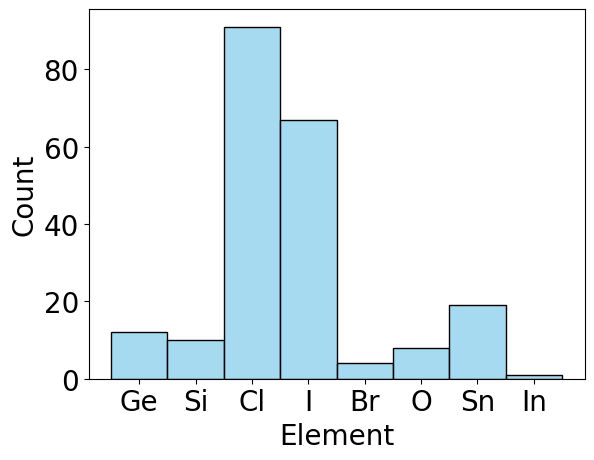

In [25]:
plt.rcParams.update({'font.size': 20})
# Create histogram
sns.histplot(df, x="Element", discrete=True, color="skyblue")

# Labels and title
plt.xlabel("Element")
plt.ylabel("Count")
plt.savefig("Histogram_Element.tiff", format='tiff', dpi=600, bbox_inches='tight')

# Show plot
plt.show()

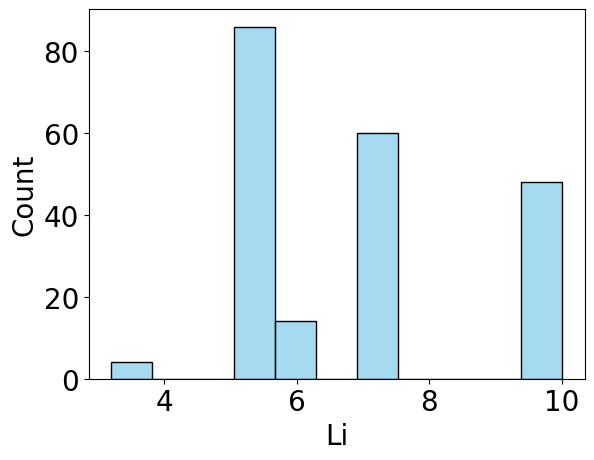

In [26]:
plt.rcParams.update({'font.size': 20})

# Create histogram
sns.histplot(df, x="Li", discrete=False, color="skyblue")

# Labels and title
plt.xlabel("Li")
plt.ylabel("Count")
plt.savefig("Histogram_Li.tiff", format='tiff', dpi=600, bbox_inches='tight')

# Show plot
plt.show()

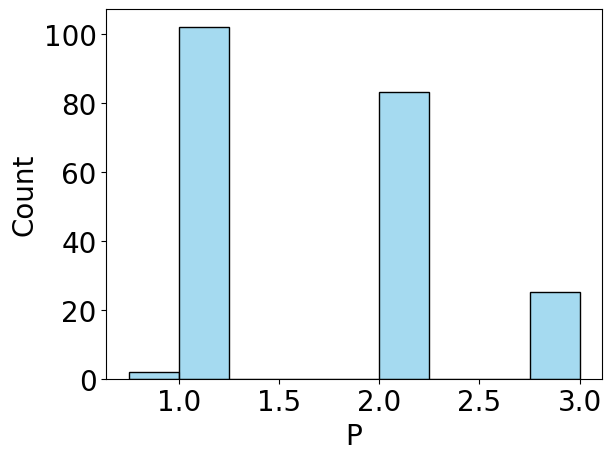

In [27]:
plt.rcParams.update({'font.size': 20})

# Create histogram
sns.histplot(df, x="P", discrete=False, color="skyblue")

# Labels and title
plt.xlabel("P")
plt.ylabel("Count")
plt.savefig("Histogram_P.tiff", format='tiff', dpi=600, bbox_inches='tight')

# Show plot
plt.show()

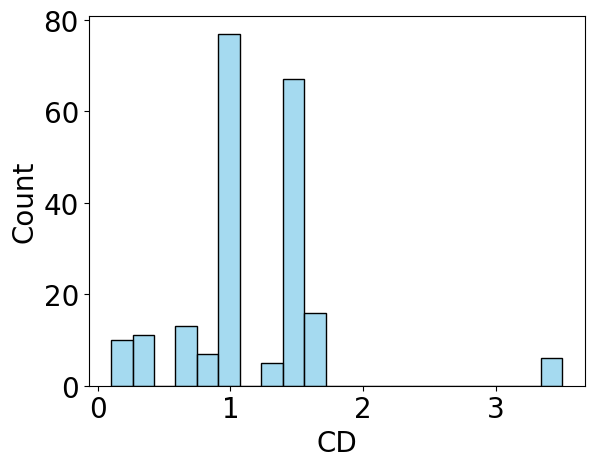

In [28]:
plt.rcParams.update({'font.size': 20})

# Create histogram
sns.histplot(df, x="CD", discrete=False, color="skyblue")

# Labels and title
plt.xlabel("CD")
plt.ylabel("Count")
plt.savefig("Histogram_CD.tiff", format='tiff', dpi=600, bbox_inches='tight')

# Show plot
plt.show()

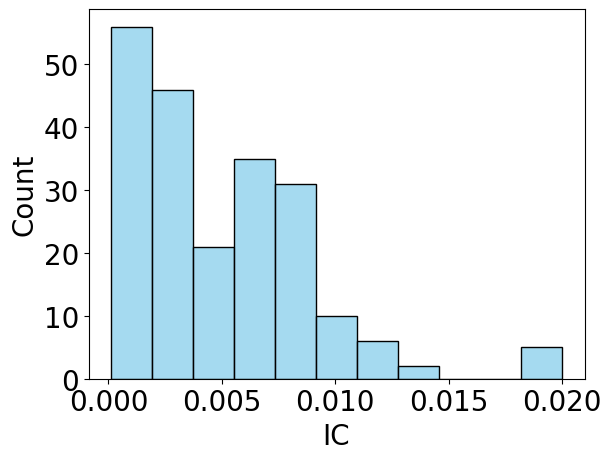

In [29]:
plt.rcParams.update({'font.size': 20})

# Create histogram
sns.histplot(df, x="IC", discrete=False, color="skyblue")

# Labels and title
plt.xlabel("IC")
plt.ylabel("Count")
plt.savefig("Histogram_IC.tiff", format='tiff', dpi=600, bbox_inches='tight')

# Show plot
plt.show()

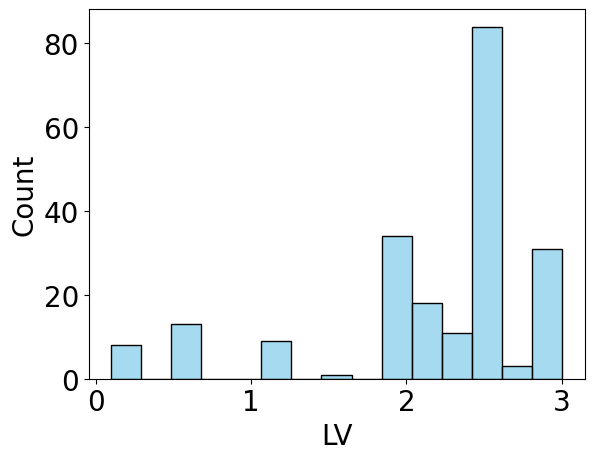

In [30]:
plt.rcParams.update({'font.size': 20})

# Create histogram
sns.histplot(df, x="LV", discrete=False, color="skyblue")

# Labels and title
plt.xlabel("LV")
plt.ylabel("Count")
plt.savefig("Histogram_LV.tiff", format='tiff', dpi=600, bbox_inches='tight')

# Show plot
plt.show()

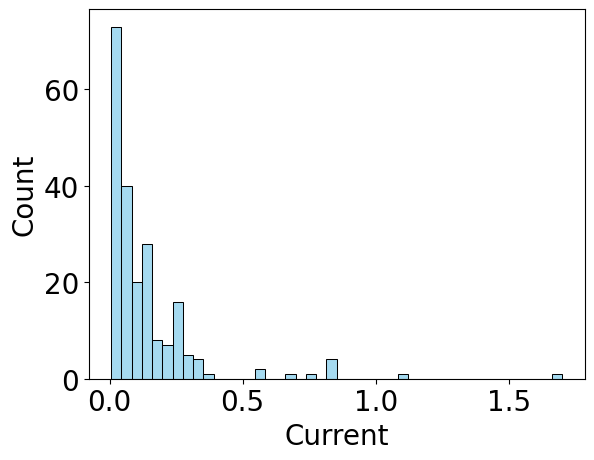

In [31]:
plt.rcParams.update({'font.size': 20})

# Create histogram
sns.histplot(df, x="Current", discrete=False, color="skyblue")

# Labels and title
plt.xlabel("Current")
plt.ylabel("Count")
plt.savefig("Histogram_Current.tiff", format='tiff', dpi=600, bbox_inches='tight')

# Show plot
plt.show()

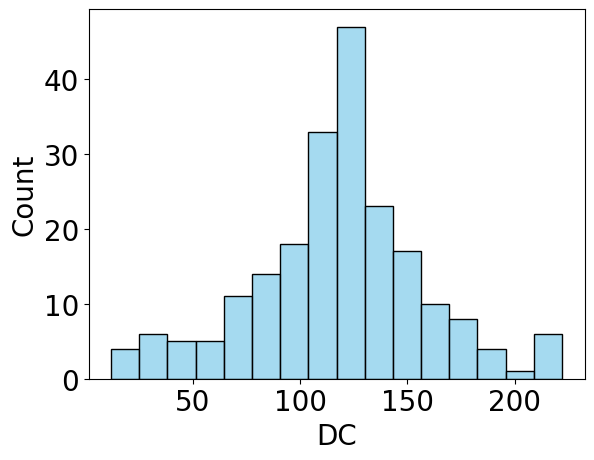

In [32]:
plt.rcParams.update({'font.size': 20})

# Create histogram
sns.histplot(df, x="DC", discrete=False, color="skyblue")

# Labels and title
plt.xlabel("DC")
plt.ylabel("Count")
plt.savefig("Histogram_DC.tiff", format='tiff', dpi=600, bbox_inches='tight')

# Show plot
plt.show()

## Pearson Correlation

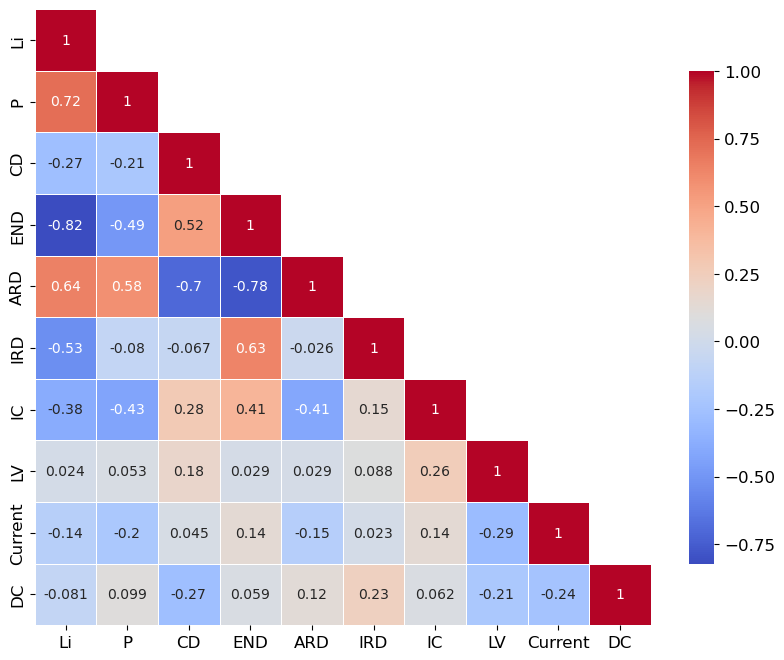

In [33]:
plt.rcParams.update({'font.size': 12})

# Drop the "Dopant" column if it exists
temp_df = df.drop(columns=["Element"])

# Calculate the correlation matrix (Pearson by default)
corr_matrix = temp_df.corr()

# Create a mask for the upper triangle (excluding the diagonal)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)  # k=1 excludes the diagonal

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap with the mask
sns.heatmap(
    corr_matrix, 
    mask=mask, 
    annot=True, 
    cmap='coolwarm', 
    square=True, 
    linewidths=0.5, 
    cbar_kws={"shrink": 0.8},
    annot_kws={"fontsize": 10}
)
plt.savefig("Pearson.tiff", format='tiff', dpi=600, bbox_inches='tight')
plt.show()

## Random Forest

In [35]:
import optuna
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestRegressor
from typing import Dict



# --- Reproducibility ---
SEED = 42
np.random.seed(SEED)

# --- Preprocessing and Held-Out Test Split ---
if "Element" in df.columns:
    df = df.drop(columns=["Element"])

target_column = "DC"
feature_names = df.drop(columns=[target_column]).columns.tolist()

scaler = StandardScaler()
X_full = scaler.fit_transform(df.drop(columns=[target_column]).to_numpy())
y_full = df[target_column].to_numpy()

# Binning target for stratified split
y_full_binned = pd.qcut(y_full, q=10, duplicates="drop", labels=False)

X_train_val, X_test, y_train_val, y_test, y_train_val_binned, _ = train_test_split(
    X_full, y_full, y_full_binned, test_size=0.15, random_state=SEED, stratify=y_full_binned
)

# --- Evaluation Metrics Function ---
def eval_metrics(y_true: np.ndarray, y_pred: np.ndarray, n_features: int) -> Dict:
    n = len(y_true)
    p = n_features
    metrics = {
        "Mean Squared Error (MSE)": mean_squared_error(y_true, y_pred),
        "Root Mean Squared Error (RMSE)": np.sqrt(mean_squared_error(y_true, y_pred)),
        "Mean Absolute Error (MAE)": mean_absolute_error(y_true, y_pred),
        "R² Score": r2_score(y_true, y_pred),
    }
    return metrics

# --- Define the Objective Function with Stratified K-Fold CV ---
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 500)
    max_depth = trial.suggest_int("max_depth", 3, 20)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 5)

    skf = StratifiedKFold(n_splits=8, shuffle=True, random_state=SEED)
    r2_scores = []

    for train_index, val_index in skf.split(X_train_val, y_train_val_binned):
        X_train_fold, X_val_fold = X_train_val[train_index], X_train_val[val_index]
        y_train_fold, y_val_fold = y_train_val[train_index], y_train_val[val_index]

        model = RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            random_state=SEED,
            n_jobs=-1,
        )
        model.fit(X_train_fold, y_train_fold)

        preds = model.predict(X_val_fold)
        r2_scores.append(r2_score(y_val_fold, preds))

    return np.mean(r2_scores)

# --- Hyperparameter Optimization using Optuna ---
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=SEED))
study.optimize(objective, n_trials=100)

best_params = study.best_params
print("\nBest Hyperparameters:", best_params)

# --- Cross-Validation with Best Params ---
def cross_validate_model(X, y, y_binned, best_params, n_splits=8):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    cv_results = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y_binned), 1):
        X_train_fold, X_val_fold = X[train_idx], X[val_idx]
        y_train_fold, y_val_fold = y[train_idx], y[val_idx]

        model = RandomForestRegressor(
            **best_params,
            random_state=SEED,
            n_jobs=-1
        )
        model.fit(X_train_fold, y_train_fold)

        preds = model.predict(X_val_fold)
        metrics = eval_metrics(y_val_fold, preds, X.shape[1])
        cv_results.append(metrics)


cv_metrics = cross_validate_model(X_train_val, y_train_val, y_train_val_binned, best_params, n_splits=8)

# --- Final Model Training on Train+Val ---
best_model = RandomForestRegressor(**best_params, random_state=SEED, n_jobs=-1)
best_model.fit(X_train_val, y_train_val)

# --- Evaluate on Training Set ---
y_train_pred = best_model.predict(X_train_val)
train_metrics = eval_metrics(y_train_val, y_train_pred, X_train_val.shape[1])
print("\n=== Final Training Metrics === ")
for k, v in train_metrics.items():
    print(f"{k}: {v:.4f}")

# --- Evaluate on Test Set ---
y_test_pred = best_model.predict(X_test)
test_metrics = eval_metrics(y_test, y_test_pred, X_test.shape[1])
print("\n=== Final Testing Metrics === ")
for k, v in test_metrics.items():
    print(f"{k}: {v:.4f}")

[I 2025-09-25 11:20:56,484] A new study created in memory with name: no-name-74ff5d71-fdef-46ea-9578-bd3650571b1e


[I 2025-09-25 11:20:59,277] Trial 0 finished with value: 0.40734816400684737 and parameters: {'n_estimators': 218, 'max_depth': 20, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.40734816400684737.
[I 2025-09-25 11:21:00,443] Trial 1 finished with value: 0.34074014877981845 and parameters: {'n_estimators': 120, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.40734816400684737.
[I 2025-09-25 11:21:03,180] Trial 2 finished with value: 0.3679339938466791 and parameters: {'n_estimators': 321, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.40734816400684737.
[I 2025-09-25 11:21:06,812] Trial 3 finished with value: 0.4246761476422316 and parameters: {'n_estimators': 425, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 3 with value: 0.4246761476422316.
[I 2025-09-25 11:21:08,879] Trial 4 finished with value: 0.4481875554369755 and parameter


Best Hyperparameters: {'n_estimators': 378, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 1}

=== Final Training Metrics === 
Mean Squared Error (MSE): 135.0362
Root Mean Squared Error (RMSE): 11.6205
Mean Absolute Error (MAE): 8.0951
R² Score: 0.9156

=== Final Testing Metrics === 
Mean Squared Error (MSE): 328.9254
Root Mean Squared Error (RMSE): 18.1363
Mean Absolute Error (MAE): 11.5897
R² Score: 0.7740


## Gradient Boosting Regressor

In [36]:
# --- Imports ---
import optuna
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, StratifiedKFold
import shap
from typing import Dict

# --- Load your DataFrame ---
# df = pd.read_csv('Data_driven.csv')  

###--- Reproducibility
SEED = 42
np.random.seed(SEED)

# --- Preprocess ---
if "Element" in df.columns:
    df = df.drop(columns=["Element"])

target_column = "DC"
feature_names = df.drop(columns=[target_column]).columns.tolist()
X_full = df.drop(columns=[target_column]).to_numpy()
y_full = df[target_column].to_numpy()

# Bin target for stratified split (for regression stratification)
y_full_binned = pd.qcut(y_full, q=10, duplicates="drop", labels=False)

# Train-test split
X_train_val, X_test, y_train_val, y_test, y_train_val_binned, _ = train_test_split(
    X_full, y_full, y_full_binned, test_size=0.15, random_state=SEED, stratify=y_full_binned
)

# --- Evaluation Metrics ---
def eval_metrics(y_true: np.ndarray, y_pred: np.ndarray, n_features: int) -> Dict:
    n = len(y_true)
    p = n_features
    return {
        "MSE": mean_squared_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE": mean_absolute_error(y_true, y_pred),
        "R²": r2_score(y_true, y_pred),
    }

# --- Optuna Objective Function ---
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 1.0),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 5),
        "random_state": SEED
    }
    
    skf = StratifiedKFold(n_splits=8, shuffle=True, random_state=SEED)
    r2_scores = []
    
    for train_idx, val_idx in skf.split(X_train_val, y_train_val_binned):
        X_tr, X_val = X_train_val[train_idx], X_train_val[val_idx]
        y_tr, y_val = y_train_val[train_idx], y_train_val[val_idx]

        scaler = StandardScaler()
        X_tr_scaled = scaler.fit_transform(X_tr)
        X_val_scaled = scaler.transform(X_val)

        model = GradientBoostingRegressor(**params)
        model.fit(X_tr_scaled, y_tr)

        preds = model.predict(X_val_scaled)
        r2_scores.append(r2_score(y_val, preds))
    
    return np.mean(r2_scores)

# --- Run Hyperparameter Optimization ---
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=SEED))
study.optimize(objective, n_trials=100)

best_params = study.best_params
print(f"\nBest Hyperparameters: {best_params}\n")

# --- Final Training with Best Params ---
scaler_final = StandardScaler()
X_train_val_scaled = scaler_final.fit_transform(X_train_val)
X_test_scaled = scaler_final.transform(X_test)

best_model = GradientBoostingRegressor(**best_params, random_state=SEED)
best_model.fit(X_train_val_scaled, y_train_val)

# --- K-Fold CV Evaluation on Train+Val ---
skf_final = StratifiedKFold(n_splits=8, shuffle=True, random_state=SEED)
cv_scores = []

for train_idx, val_idx in skf_final.split(X_train_val, y_train_val_binned):
    X_tr, X_val = X_train_val[train_idx], X_train_val[val_idx]
    y_tr, y_val = y_train_val[train_idx], y_train_val[val_idx]

    X_tr_scaled = scaler_final.fit_transform(X_tr)
    X_val_scaled = scaler_final.transform(X_val)

    model = GradientBoostingRegressor(**best_params, random_state=SEED)
    model.fit(X_tr_scaled, y_tr)

    preds_val = model.predict(X_val_scaled)
    cv_scores.append(r2_score(y_val, preds_val))

# --- Predictions ---
y_pred_train_val = best_model.predict(X_train_val_scaled)
y_pred_test = best_model.predict(X_test_scaled)

train_metrics = eval_metrics(y_train_val, y_pred_train_val, X_train_val.shape[1])
test_metrics = eval_metrics(y_test, y_pred_test, X_test.shape[1])

print("\n=== Final Training Metrics === ")
for k, v in train_metrics.items():
    print(f"{k}: {v:.4f}")

print("\n=== Final Testing Metrics === ")
for k, v in test_metrics.items():
    print(f"{k}: {v:.4f}")

[I 2025-09-25 12:31:31,254] A new study created in memory with name: no-name-ad5446a1-390c-434b-b310-27231a463718
[I 2025-09-25 12:31:32,767] Trial 0 finished with value: 0.24412363908748017 and parameters: {'n_estimators': 218, 'learning_rate': 0.951207163345817, 'max_depth': 12, 'min_samples_split': 7, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.24412363908748017.
[I 2025-09-25 12:31:33,545] Trial 1 finished with value: 0.4561650995988862 and parameters: {'n_estimators': 120, 'learning_rate': 0.06750277604651747, 'max_depth': 14, 'min_samples_split': 7, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.4561650995988862.
[I 2025-09-25 12:31:34,037] Trial 2 finished with value: 0.3506098182327216 and parameters: {'n_estimators': 59, 'learning_rate': 0.9702107536403743, 'max_depth': 13, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.4561650995988862.
[I 2025-09-25 12:31:34,844] Trial 3 finished with value: 0.4298881778957185 and parameters: {


Best Hyperparameters: {'n_estimators': 345, 'learning_rate': 0.27410727426104836, 'max_depth': 12, 'min_samples_split': 6, 'min_samples_leaf': 5}


=== Final Training Metrics === 
MSE: 45.4467
RMSE: 6.7414
MAE: 2.1486
R²: 0.9716

=== Final Testing Metrics === 
MSE: 279.0858
RMSE: 16.7059
MAE: 10.4828
R²: 0.8083


## XGBoost 

[I 2025-09-28 21:36:41,660] A new study created in memory with name: no-name-580a0f83-6e8d-4f23-9581-60d68cbd5536


[I 2025-09-28 21:36:43,514] Trial 0 finished with value: 0.5136584565043449 and parameters: {'n_estimators': 218, 'max_depth': 12, 'learning_rate': 0.21962498314924037, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182, 'gamma': 0.7799726016810132, 'reg_lambda': 0.2904180608409973, 'reg_alpha': 4.330880728874676, 'min_child_weight': 7}. Best is trial 0 with value: 0.5136584565043449.
[I 2025-09-28 21:36:46,290] Trial 1 finished with value: 0.5275435075163841 and parameters: {'n_estimators': 369, 'max_depth': 3, 'learning_rate': 0.2909759646633821, 'subsample': 0.9162213204002109, 'colsample_bytree': 0.6061695553391381, 'gamma': 0.9091248360355031, 'reg_lambda': 0.9170225492671691, 'reg_alpha': 1.5212112147976886, 'min_child_weight': 6}. Best is trial 1 with value: 0.5275435075163841.
[I 2025-09-28 21:36:48,455] Trial 2 finished with value: 0.5017114132642746 and parameters: {'n_estimators': 244, 'max_depth': 5, 'learning_rate': 0.1835946831272416, 'subsample': 0.5

Best Hyperparameters: {'n_estimators': 285, 'max_depth': 4, 'learning_rate': 0.1372960240882706, 'subsample': 0.7556684250749207, 'colsample_bytree': 0.6167249006900615, 'gamma': 4.706575996313049, 'reg_lambda': 0.5354996607995398, 'reg_alpha': 2.4275949732225106, 'min_child_weight': 6}

=== Final Training Metrics===
Mean Squared Error (MSE): 84.0491
Root Mean Squared Error (RMSE): 9.1678
Mean Absolute Error (MAE): 5.8911
R² Score: 0.9474

=== Final Testing Metrics===
Mean Squared Error (MSE): 241.3296
Root Mean Squared Error (RMSE): 15.5348
Mean Absolute Error (MAE): 10.7768
R² Score: 0.8342


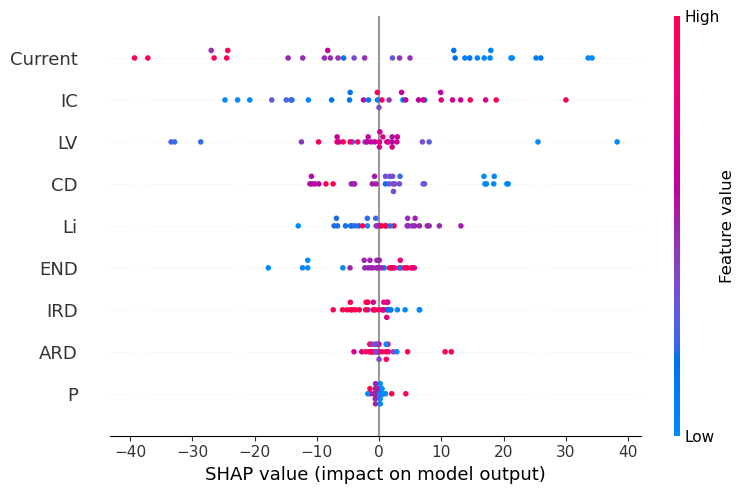

In [42]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from xgboost import XGBRegressor
import shap
from typing import Dict
import optuna

# --- Load your DataFrame ---
# df = pd.read_csv('Data_driven.csv')  

# --- Reproducibility ---
SEED = 42
np.random.seed(SEED)

# --- Load your DataFrame ---
# (Assume df is already loaded externally)
if "Element" in df.columns:
    df = df.drop(columns=["Element"])

# Define features and target
target_column = "DC"
feature_names = df.drop(columns=[target_column]).columns.tolist()
X_full = df.drop(columns=[target_column]).to_numpy()
y_full = df[target_column].to_numpy()

# Bin target for stratified split (important for regression tasks)
y_full_binned = pd.qcut(y_full, q=10, duplicates="drop", labels=False)

# Split into train+val and test sets
X_train_val, X_test, y_train_val, y_test, y_train_val_binned, _ = train_test_split(
    X_full, y_full, y_full_binned,
    test_size=0.15, random_state=SEED, stratify=y_full_binned
)

# --- Evaluation Metrics Function ---
def eval_metrics(y_true: np.ndarray, y_pred: np.ndarray, n_features: int) -> Dict:
    n = len(y_true)
    p = n_features
    metrics = {
        "Mean Squared Error (MSE)": mean_squared_error(y_true, y_pred),
        "Root Mean Squared Error (RMSE)": np.sqrt(mean_squared_error(y_true, y_pred)),
        "Mean Absolute Error (MAE)": mean_absolute_error(y_true, y_pred),
        "R² Score": r2_score(y_true, y_pred),
    }
    return metrics


# --- Hyperparameter Optimization ---
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.3),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 5),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 5),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "random_state": SEED,
    }

    skf = StratifiedKFold(n_splits=8, shuffle=True, random_state=SEED)
    r2_scores = []

    for train_idx, val_idx in skf.split(X_train_val, y_train_val_binned):
        X_train_fold, X_val_fold = X_train_val[train_idx], X_train_val[val_idx]
        y_train_fold, y_val_fold = y_train_val[train_idx], y_train_val[val_idx]

        scaler = StandardScaler()
        X_train_fold_scaled = scaler.fit_transform(X_train_fold)
        X_val_fold_scaled = scaler.transform(X_val_fold)

        model = XGBRegressor(**params, objective="reg:squarederror")
        model.fit(X_train_fold_scaled, y_train_fold, 
                  eval_set=[(X_val_fold_scaled, y_val_fold)], verbose=False)

        preds = model.predict(X_val_fold_scaled)
        r2_scores.append(r2_score(y_val_fold, preds))

    return np.mean(r2_scores)


# --- Run Optuna Study ---
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=SEED))
study.optimize(objective, n_trials=100)

best_params = study.best_params
print(f"Best Hyperparameters: {best_params}")


# --- Final Cross-Validation with Best Params ---
def cross_validate_model(X, y, y_binned, best_params, n_splits=8):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    cv_results = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y_binned), 1):
        X_train_fold, X_val_fold = X[train_idx], X[val_idx]
        y_train_fold, y_val_fold = y[train_idx], y[val_idx]

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_fold)
        X_val_scaled = scaler.transform(X_val_fold)

        model = XGBRegressor(**best_params, objective="reg:squarederror")
        model.fit(X_train_scaled, y_train_fold, verbose=False)

        preds = model.predict(X_val_scaled)
        metrics = eval_metrics(y_val_fold, preds, X.shape[1])
        cv_results.append(metrics)


# Run k-fold CV on train+val
cv_metrics = cross_validate_model(X_train_val, y_train_val, y_train_val_binned, best_params, n_splits=8)


# --- Final Training on Train+Val and Evaluation on Test ---
scaler_final = StandardScaler()
X_train_val_scaled = scaler_final.fit_transform(X_train_val)
X_test_scaled = scaler_final.transform(X_test)

best_model = XGBRegressor(**best_params, objective="reg:squarederror")
best_model.fit(X_train_val_scaled, y_train_val)

# Predictions
y_pred_train_val = best_model.predict(X_train_val_scaled)
y_pred_test = best_model.predict(X_test_scaled)

# Evaluate Metrics
train_metrics = eval_metrics(y_train_val, y_pred_train_val, X_train_val.shape[1])
test_metrics = eval_metrics(y_test, y_pred_test, X_test.shape[1])

print("\n=== Final Training Metrics===")
for k, v in train_metrics.items():
    print(f"{k}: {v:.4f}")

print("\n=== Final Testing Metrics===")
for k, v in test_metrics.items():
    print(f"{k}: {v:.4f}")

# --- SHAP Analysis ---
shap.initjs()
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test_scaled)
shap.summary_plot(shap_values, X_test_scaled, feature_names=feature_names, show=False)
plt.savefig("shap_summary.tiff", format="tiff", dpi=600, bbox_inches='tight')

### Dependence plot

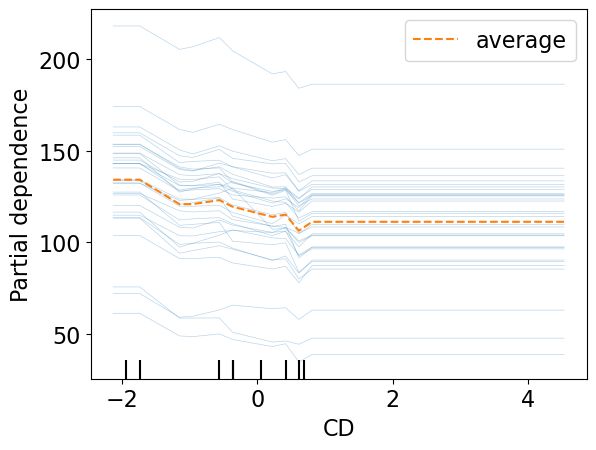

In [43]:
from sklearn.inspection import PartialDependenceDisplay
plt.rcParams.update({'font.size': 16})
PartialDependenceDisplay.from_estimator(best_model, X_test_scaled, [2],
    kind='both', feature_names = feature_names)
#plt.savefig("ICE_PD_plot_CD.svg")
plt.savefig("ICE_PD_plot_CD.tiff", format='tiff', dpi=600, bbox_inches='tight')

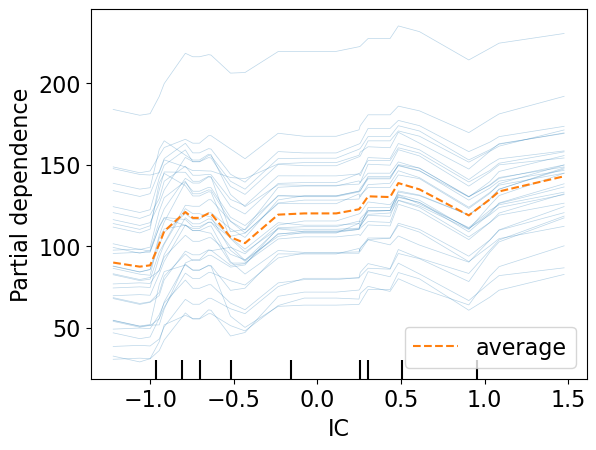

In [44]:
from sklearn.inspection import PartialDependenceDisplay
plt.rcParams.update({'font.size': 16})
PartialDependenceDisplay.from_estimator(best_model, X_test_scaled, [6],
    kind='both', feature_names = feature_names)
#plt.savefig("ICE_PD_plot_IC.svg")
plt.savefig("ICE_PD_plot_IC.tiff", format='tiff', dpi=600, bbox_inches='tight')

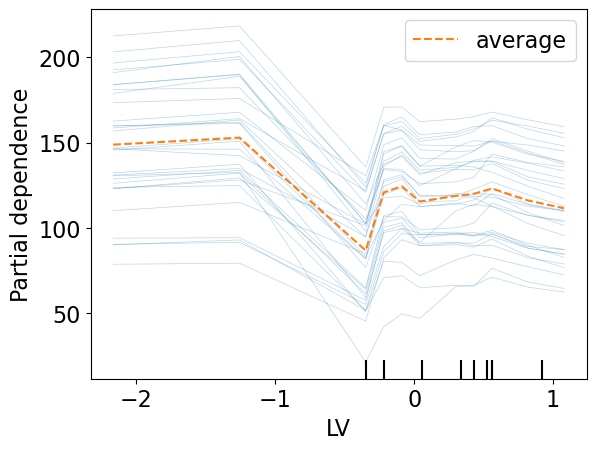

In [45]:
from sklearn.inspection import PartialDependenceDisplay
plt.rcParams.update({'font.size': 16})
PartialDependenceDisplay.from_estimator(best_model, X_test_scaled, [7],
    kind='both', feature_names = feature_names)
#plt.savefig("ICE_PD_plot_LV.svg")
plt.savefig("ICE_PD_plot_LV.tiff", format='tiff', dpi=600, bbox_inches='tight')

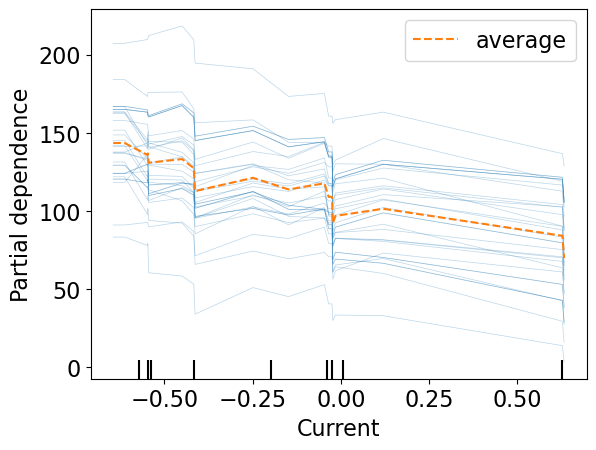

In [46]:
from sklearn.inspection import PartialDependenceDisplay
plt.rcParams.update({'font.size': 16})
PartialDependenceDisplay.from_estimator(best_model, X_test_scaled, [8],
    kind='both', feature_names = feature_names)
plt.savefig("ICE_PD_plot_Current.tiff", format='tiff', dpi=600, bbox_inches='tight')